In [1]:
import re
import numpy as np
import pandas as pd
from keras.models import *
from keras.layers import *
from keras.layers import *
from keras import optimizers
from keras.utils import np_utils
from keras.callbacks import TensorBoard
from keras.models import load_model
import math
import os.path
from keras.optimizers import *

Using TensorFlow backend.


/Users/Zizy/anaconda/envs/tensorflow/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [2]:
reg = "(.*) (.*) (.*)\@(.*)\^(.*)\-(.*)\+(.*)\=(.*)\_(.*)\%(.*)\^(.*)\_(.*)\~(.*)\-(.*)\!(.*)\[(.*)\$(.*)\](.*)/A:(.*)\-(.*)\-(.*)\@(.*)\~(.*)/B:(.*)\_(.*)\_(.*)\@(.*)\|(.*)/C:(.*)\+(.*)\+(.*)\@(.*)\&(.*)/D:(.*)\!(.*)\#(.*)\$(.*)\%(.*)\|(.*)\&(.*)\;(.*)\-(.*)/E:(.*)\](.*)\^(.*)\=(.*)\~(.*)\!(.*)\@(.*)\#(.*)\+(.*)\](.*)\$(.*)\|(.*)\[(.*)\&(.*)\](.*)\=(.*)\^(.*)\~(.*)\#(.*)\_(.*)\;(.*)\$(.*)\&(.*)\%(.*)\[(.*)\|(.*)\](.*)\-(.*)\^(.*)\+(.*)\~(.*)\=(.*)\@(.*)\$(.*)\!(.*)\%(.*)\#(.*)\|(.*)\|(.*)\-(.*)\&(.*)\&(.*)\+(.*)\[(.*)\;(.*)\](.*)\;(.*)\~(.*)\~(.*)\^(.*)\^(.*)\@(.*)\[(.*)\#(.*)\=(.*)\!(.*)\~(.*)\+(.*)\!(.*)\^(.*)/F:(.*)\#(.*)\#(.*)\-(.*)\$(.*)\$(.*)\+(.*)\%(.*)\;(.*)/G:(.*)\_(.*)/H:(.*)\_(.*)/I:(.*)\_(.*)/J:(.*)\~(.*)\@(.*)"
li = re.findall(reg,"0 12000000 p@xx^xx-pau+d=e_xx%xx^00_00~00-1!1[xx$xx]xx/A:xx-xx-xx@xx~xx/B:1_1_1@xx|xx/C:2+1+1@JPN&0/D:xx!xx#xx$xx%xx|xx&xx;xx-xx/E:xx]xx^2=2/4~100!1@120#48+xx]1$1|0[12&0]48=0^100~xx#xx_xx;xx$xx&xx%xx[xx|0]0-n^xx+xx~xx=xx@xx$xx!xx%xx#xx|xx|xx-xx&xx&xx+xx[xx;xx]xx;xx~xx~xx^xx^xx@xx[xx#xx=xx!xx~xx+xx!xx^xx/F:A4#7#2-2/4$100$1+45%18;xx/G:xx_xx/H:xx_xx/I:13_13/J:3~3@6")

phonemes = ['pau','xx'] +["ny","ty","py","ky","ry","f","br","sil","cl","a","i","u","e","o","k","g","s","z","sh","j","t","d","ch","q","ts","h","b","p","m","y","r","w","N","n","v" ]
pitches = ['xx']+[pitch + str(i) for i in range(1,8) for pitch in ["C", "Db", "D", "Eb", "E", "F", "Gb", "G", "Ab", "A", "Bb", "B"]] 
BOS=9999

local_path='/Users/Zizy/Programming/HKU/Dissertation/'

lbl_name = ['t0','t1']+['p' + str(i) for i in range(1, 17)] + \
           ['a' + str(i) for i in range(1, 6)] + \
           ['b' + str(i) for i in range(1, 6)] + \
           ['c' + str(i) for i in range(1, 6)] + \
           ['d' + str(i) for i in range(1, 10)] + \
           ['e' + str(i) for i in range(1, 61)] + \
           ['f' + str(i) for i in range(1, 10)] + \
           ['g' + str(i) for i in range(1, 3)] + \
           ['h' + str(i) for i in range(1, 3)] + \
           ['i' + str(i) for i in range(1, 3)] + \
           ['j' + str(i) for i in range(1, 4)] 
print(len(li[0]))
NUM_OUT_PUT= 20

120


In [6]:
def read_songs_labels():
    labs = []
    for i in range(0, 71):
        label_file_name = 'nitech_jp_song070_f001_0' + (('0' + str(i)) if i < 10 else str(i)) + '.lab'
        if not os.path.isfile(local_path + 'lab/' + label_file_name):
            continue
        with open(local_path + 'lab/' + label_file_name, 'r') as lab_file:
            lines = lab_file.readlines()
            params_list = []
            for line in lines:
                ps = re.findall(reg, line)
                params_list.append(ps[0])
            temp = []
            for params in params_list:
                params_temp = {}
                for i in range(0, 120):
                    params_temp[lbl_name[i]] = params[i]
                temp.append(params_temp)
            params_list = temp

            labs.append(params_list)
    return labs


def make_one_hot(data1, size):
    data1 = np.array(data1)
    return (np.arange(size) == data1[:, None]).astype(np.integer)


def make_class(data, classes):
    return [classes.index(p) for p in data]

def get_params_by_name(name, params_list):
    return [params[name] for params in params_list]


def convert_params_to_one_hot(name, classes, params_list):
    data = get_params_by_name(name, params_list)
    data = make_class(data, classes)
    data = make_one_hot(data, len(classes))
    return data


# with mono file updated
def read_songs_labels_with_mono():
    labs = []
    for i in range(0, 71):
        label_file_name = 'nitech_jp_song070_f001_0' + (('0' + str(i)) if i < 10 else str(i)) + '.lab'
        if not os.path.isfile(local_path + 'lab/' + label_file_name):
            continue
        if not os.path.isfile(local_path + 'mono/' + label_file_name):
            continue

        lab_file = open(local_path + 'lab/' + label_file_name, 'r')
        lab_file_mono = open(local_path + 'mono/' + label_file_name, 'r')
        lines = lab_file.readlines()
        lines_mono = lab_file_mono.readlines()
        params_list = []
        for index, line in enumerate(lines):
            ps = list(re.findall(reg, line)[0])
            ps2 = re.findall("(.*) (.*) (.*)", lines_mono[index])[0]

            ps[0] = ps2[0]
            ps[1] = ps2[1]
            params_list.append(ps)
        temp = []
        for params in params_list:
            params_temp = {}
            for i in range(0, 120):
                params_temp[lbl_name[i]] = params[i]
            temp.append(params_temp)
        params_list = temp

        lab_file.close()
        lab_file_mono.close()

        labs.append(params_list)
    return labs


def feature_expend(labs):
    modified_labs = []
    for index, lab_file in enumerate(labs):
        modified_labs.append([])
        max_time_stamp = int(lab_file[-1]["t1"])
        # max_time_stamp / 10000 = ms
        f0_size = math.ceil((max_time_stamp / 10000 / 5)) + 1
        sample_index = 0
        for sample in range(0, f0_size):
            if int(lab_file[sample_index]["t1"]) / 10000 / 5 > sample:
                modified_labs[index].append(lab_file[sample_index])
            else:
                if len(lab_file) > sample_index + 1:
                    sample_index += 1
                modified_labs[index].append(lab_file[sample_index])

    return modified_labs


def sp_feature_extract(labs):
    stacked_labs_with_feature = []
    feature_num = 0

    temp = []
    for lab in labs:
        temp.append(len(lab))
    max_sample_size = max(temp)
    print("max sample size: %s" % max_sample_size)

    for lab in labs:
        params_phonemes_one_hot = convert_params_to_one_hot('p4', phonemes, lab)
        params_phonemes_pre_one_hot = convert_params_to_one_hot('p3', phonemes, lab)
        params_phonemes_next_one_hot = convert_params_to_one_hot('p5', phonemes, lab)
        params_phonemes_position = get_params_by_name('p12', lab)

        stacked_feature = np.hstack([params_phonemes_one_hot,
                                     params_phonemes_pre_one_hot,
                                     params_phonemes_next_one_hot,
                                     np.reshape(params_phonemes_position, (len(params_phonemes_position), 1)),
                                     ])
        stacked_feature = np.vstack([stacked_feature,
                                     np.zeros((max_sample_size - stacked_feature.shape[0], stacked_feature.shape[1]))])

        stacked_labs_with_feature.append(stacked_feature)

    stacked_labs_with_feature = np.array(stacked_labs_with_feature)
    return stacked_labs_with_feature


def read_f0s():
    max_f0_size = 0
    f0s = []
    for i in range(0, 71):
        f0_file_name = 'nitech_jp_song070_f001_0' + (('0' + str(i)) if i < 10 else str(i)) + '_f0.txt'
        if not os.path.isfile(local_path + 'gen/' + f0_file_name):
            continue
        with open(local_path + 'gen/' + f0_file_name, 'r') as f0_file:
            lines = f0_file.readlines()
            lines = np.array(lines).astype(np.float)

            if len(lines) > max_f0_size:
                max_f0_size = len(lines)
            f0s.append(lines)

    # 即要生成的最多个f0，
    print(max_f0_size)

    for index, f0 in enumerate(f0s):
        f0s[index] = np.append(f0, np.zeros(max_f0_size - len(f0)))

    f0s = np.array(f0s)
    f0s = np.reshape(f0s, (f0s.shape[0], f0s.shape[1], 1))

    # (31, max_f0_size, 1)
    return f0s, max_f0_size


def features_add_f0(labs, f0s):
    result = np.zeros((labs.shape[0], labs.shape[1], labs.shape[2] + 1))
    for i in range(0, labs.shape[0]):
        result[i] = np.hstack([labs[i], f0s[i]])
    return result


def read_sp():
    max_sp_size = 0
    sps = []
    for i in range(0, 10):
        sp_file_name = 'nitech_jp_song070_f001_0' + (('0' + str(i)) if i < 10 else str(i)) + '_sp.txt'
        if not os.path.isfile(local_path + 'gen/' + sp_file_name):
            continue
        with open(local_path + 'gen/' + sp_file_name, 'r') as sp_file:
            lines = sp_file.readlines()
            lines = np.array(lines)
            new_lines = []
            for line in lines:
                new_lines.append(np.array(line.split(',')).astype(float))
            new_lines = np.array(new_lines)
            if len(lines) > max_sp_size:
                max_sp_size = len(lines)
            sps.append(new_lines)
            print(len(sps))

    # 即要生成的最多个sp，
    print(max_sp_size)

    for index, sp in enumerate(sps):
        sps[index]=np.vstack([sps[index], np.zeros((max_sp_size-len(sp),1025))])
    sps = np.array(sps)
    return sps, max_sp_size


In [7]:
local_path='/Users/Zizy/Programming/HKU/Dissertation/'


In [9]:
labs = read_songs_labels_with_mono()
labs = feature_expend(labs)
labs = sp_feature_extract(labs)
f0s, max_f0_size = read_f0s()
labs = features_add_f0(labs, f0s)
sps, _ = read_sp()

max sample size: 29761


29761


1


2


3
8640


In [88]:
def wavenetBlock(n_atrous_filters, atrous_filter_size, dilation_rate):
    def f(input_):
        residual = input_
        tanh_out = Conv1D(n_atrous_filters, atrous_filter_size,
                          dilation_rate=dilation_rate,
                          padding='causal',

                          activation='tanh')(input_)
        sigmoid_out = Conv1D(n_atrous_filters, atrous_filter_size,
                             dilation_rate=dilation_rate,
                             padding='causal',
                             activation='sigmoid')(input_)
        merged = Multiply()([tanh_out, sigmoid_out])
        skip_out = Conv1D(1, 1, activation='relu', padding='same')(merged)
        out = Add()([skip_out, residual])
        return out, skip_out

    return f


def get_basic_generative_model(input_dim):
    input_ = Input(shape=(input_dim, 1))
    A, B = wavenetBlock(64, 2, 2)(input_)
    skip_connections = [B]
    for i in range(20):
        A, B = wavenetBlock(64, 2, 2 ** ((i + 2) % 9))(A)
        skip_connections.append(B)
    net = Add()(skip_connections)
    net = Activation('relu')(net)
    net = Convolution1D(1, 1, activation='relu')(net)
    net = Convolution1D(1, 1)(net)
    net = Flatten()(net)
    # net = Dense(32, activation='relu')(net)
    net = Dense(math.ceil(1025 / 20), activation='linear')(net)
    
    
    model = Model(input=input_, output=net)
    # model.compile(loss='categorical_crossentropy', optimizer='sgd',
    #               metrics=['accuracy'])
    model.compile(loss='mse', optimizer=Adam(lr=0.0001),
                  metrics=['accuracy'])
    model.summary()
    return model


def frame_generator(total_frame, input_data_size, frame_shift, control_input, minibatch_size=20):
    X = []
    y = []
    while 1:

        for lab_file_index in range(0, len(total_frame)):
            total_frame_len = len(total_frame[lab_file_index])
            X = []
            y = []
            for cold_start_index in range(0, input_data_size):
                # frame = np.zeros((input_data_size - cold_start_index, 103))

                frame = total_frame[lab_file_index][:cold_start_index]
                new_frame = []
                for i in range(len(frame)):
                    temp = frame[i]
                    temp = [0.00000000001 if i == 0 else i for i in temp]
                    temp = np.log(temp)
                    # temp = np.fft.irfft(temp)
                    # temp = temp[:NUM_OUT_PUT]
                    # temp = np.fft.rfft(temp)
                    temp = np.array([i for index, i in enumerate(temp) if index % 20 == 0])
                    temp = -np.round(temp)
                    new_frame.append(temp)
                frame = np.array(new_frame)
                frame = np.append(np.zeros((input_data_size - cold_start_index, math.ceil(1025 / 20))) + BOS,
                                  frame)

                # frame = np.append(frame.flatten(), total_frame[lab_file_index][:cold_start_index].flatten())
                frame = np.append(frame.flatten(), control_input[lab_file_index][cold_start_index])

                # X.append(frame.reshape((input_data_size+ control_input.shape[2], 1)))
                X.append(frame.reshape((frame.shape[0], 1)))
                # print(frame.reshape((frame.shape[0], 1)).shape)
                temp = total_frame[lab_file_index][cold_start_index]

                temp = [0.00000000001 if i == 0 else i for i in temp]
                temp = np.log(temp)
                temp = np.array([i for index, i in enumerate(temp) if index % 20 == 0])
                temp = -np.round(temp)

                # temp = np.fft.irfft(temp)
                # temp = temp[:NUM_OUT_PUT]
                # temp = np.fft.rfft(temp)
                y.append(temp)
                # print(temp.shape)
                if len(X) == minibatch_size:
                    yield np.array(X), np.array(y)
                    X = []
                    y = []

            for i in range(0, total_frame_len - input_data_size - 1, frame_shift):

                # 获取一帧 (input_data_size, 1025)
                frame = total_frame[lab_file_index][i:i + input_data_size]

                # print(frame.shape)
                # print(frame.shape)

                new_frame = []
                for j in range(len(frame)):
                    temp = frame[j]
                    temp = [0.00000000001 if i == 0 else i for i in temp]
                    temp = np.log(temp)
                    temp = np.array([i for index, i in enumerate(temp) if index % 20 == 0])
                    temp = -np.round(temp)
                    # temp = np.fft.irfft(temp)
                    # temp = temp[:NUM_OUT_PUT]
                    # temp = np.fft.rfft(temp)
                    new_frame.append(temp)
                frame = np.array(new_frame)

                if len(frame) < input_data_size:
                    break

                if i + input_data_size >= total_frame_len:
                    break

                # 获取该帧 frame 后面的那个sample
                temp = total_frame[lab_file_index][i + input_data_size]
                temp = [0.00000000001 if i == 0 else i for i in temp]
                temp = np.log(temp)
                temp = np.array([i for index, i in enumerate(temp) if index % 20 == 0])
                temp = -np.round(temp)
                # temp = [0.00000000001 if i==0 else i for i in temp]
                # temp = np.log(temp) 
                # temp = np.fft.irfft(temp)
                # temp = temp[:NUM_OUT_PUT]
                # temp = np.fft.rfft(temp)
                # (1,1025)? 
                # target_val = int(temp)

                # frame.shape = (64,1)

                # Control Input
                frame = np.append(frame.flatten(), control_input[lab_file_index][i + input_data_size])
                # X值即前一帧
                X.append(frame.reshape((frame.shape[0], 1)))
                # print(frame.reshape((frame.shape[0], 1)).shape)
                y.append(temp)
                # print(temp.shape)

                # 获取一个mini-batch的数据返回
                if len(X) == minibatch_size:
                    yield np.array(X), np.array(y)
                    X = []
                    y = []


def f0_generate(model, f0_window_size, input_size, control_input):
    print('Generating audio...')
    new_f0s = np.zeros(max_f0_size)
    seed_audio = np.zeros(f0_window_size)
    curr_sample_idx = 0
    while curr_sample_idx < new_f0s.shape[0]:
        seed = np.append(seed_audio, control_input[curr_sample_idx])

        Y = np.array(model.predict(seed.reshape(1, input_size, 1)
                                   ), dtype=float)

        new_f0s[curr_sample_idx] = Y
        seed_audio[:-1] = seed_audio[1:]

        seed_audio[-1] = Y

        # percent
        # pc_str = str(round(100 * curr_sample_idx / float(new_audio.shape[0]), 2))
        # sys.stdout.write('Percent complete: ' + pc_str + '\r')
        # sys.stdout.flush()
        curr_sample_idx += 1
        if curr_sample_idx % int(new_f0s.shape[0] / 10) == 0:
            print(curr_sample_idx / int(new_f0s.shape[0] / 10))
    print('Audio generated.')
    return new_f0s.astype(np.int16)


def sp_generate(model, sp_window_size, input_size, control_input):
    print('Generating audio...')
    MAX_SP_SIZE = 7000
    new_sps = np.zeros((MAX_SP_SIZE, math.ceil(1025 / 20)))

    seed_audio = np.zeros((sp_window_size, math.ceil(1025 / 20)) + BOS)
    curr_sample_idx = 0
    while curr_sample_idx < new_sps.shape[0]:
        seed = np.append(seed_audio.flatten(), control_input[curr_sample_idx])
        Y = np.array(model.predict(seed.reshape(1, input_size, 1)
                                   ), dtype=float)

        new_sps[curr_sample_idx] = Y
        # seed_audio = seed_audio[:-1]
        # seed_audio[:-1] = seed_audio[1:]
        # seed_audio[-1] = Y
        # seed_audio = Y

        curr_sample_idx += 1
        if curr_sample_idx % int(new_sps.shape[0] / 10) == 0:
            print(curr_sample_idx / int(new_sps.shape[0] / 10))

    print('Audio generated.')
    return new_sps.astype(np.int16)


In [20]:
n_epochs = 2000
input_data_size = 64
frame_shift = 1

# model = get_basic_generative_model(input_data_size+labs.shape[2])
# (65713-control_input_size)/1025 = input_data_size: 64
# model = get_basic_generative_model(1143)
model = load_model(local_path+"sp_model_2.h5")
training_data_gen = frame_generator(sps[0:29], input_data_size, frame_shift, 
                                    labs[0:29])
validation_data_gen = frame_generator(sps[29:32], input_data_size, frame_shift, 
                                      labs[29:32])

model.fit_generator(training_data_gen, samples_per_epoch=3000, nb_epoch=n_epochs,
                    validation_data=validation_data_gen, nb_val_samples=500, verbose=1,
                    callbacks=[TensorBoard(log_dir='./tmp/log', histogram_freq=0, write_graph=True,
                                          write_images=True)])

/Users/Zizy/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:34: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/Users/Zizy/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:17: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/Users/Zizy/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., validation_steps=500, callbacks=[<keras.ca..., epochs=2000, steps_per_epoch=3000, validation_data=<generator...

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1143, 1)      0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 1143, 64)     192         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 1143, 64)     192         input_1[0][0]                    
__________________________________________________________________________________________________
multiply_1 (Multiply)           (None, 1143, 64)     0           conv1d_1[0][0]                   
                                                                 conv1d_2[0][0]                   
__________

Epoch 1/2000


KeyboardInterrupt: 

In [86]:
n_epochs = 2000
input_data_size = 5
frame_shift = 1

# model = get_basic_generative_model(input_data_size+labs.shape[2])
# (65713-control_input_size)/1025 = input_data_size: 64
model = get_basic_generative_model(input_data_size*len(np.fft.rfft(np.zeros(20)))+113)
# model = load_model(local_path+"sp_model_2.h5")
training_data_gen = frame_generator(sps[0:29], input_data_size, frame_shift, 
                                    labs[0:29])
validation_data_gen = frame_generator(sps[1:2], input_data_size, frame_shift, 
                                      labs[1:2])

# model.fit_generator(training_data_gen, samples_per_epoch=100, nb_epoch=n_epochs,
#                     validation_data=validation_data_gen, nb_val_samples=500, verbose=1,
#                     callbacks=[TensorBoard(log_dir='./tmp/log', histogram_freq=0, write_graph=True,
#                                           write_images=True)])

model.fit_generator(training_data_gen, samples_per_epoch=5000, nb_epoch=n_epochs,
                     nb_val_samples=500, verbose=1,
                    callbacks=[TensorBoard(log_dir='./tmp/log', histogram_freq=0, write_graph=True,
                                          write_images=True)])

/Users/Zizy/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:35: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
/Users/Zizy/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/Users/Zizy/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., epochs=2000, callbacks=[<keras.ca..., validation_steps=500, steps_per_epoch=5000, verbose=1)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 113, 1)       0                                            
__________________________________________________________________________________________________
conv1d_716 (Conv1D)             (None, 113, 64)      192         input_12[0][0]                   
__________________________________________________________________________________________________
conv1d_717 (Conv1D)             (None, 113, 64)      192         input_12[0][0]                   
__________________________________________________________________________________________________
multiply_232 (Multiply)         (None, 113, 64)      0           conv1d_716[0][0]                 
                                                                 conv1d_717[0][0]                 
__________

Epoch 1/2000


   1/5000 [..............................] - ETA: 2:06:01 - loss: 449.2143 - acc: 0.0500

   2/5000 [..............................] - ETA: 1:06:51 - loss: 448.7954 - acc: 0.0250

   3/5000 [..............................] - ETA: 47:02 - loss: 449.5585 - acc: 0.0333  

   4/5000 [..............................] - ETA: 37:16 - loss: 450.1448 - acc: 0.0250

   5/5000 [..............................] - ETA: 31:26 - loss: 448.7058 - acc: 0.0300

   6/5000 [..............................] - ETA: 27:32 - loss: 448.2072 - acc: 0.0250

   7/5000 [..............................] - ETA: 24:43 - loss: 447.1831 - acc: 0.0214

   8/5000 [..............................] - ETA: 22:35 - loss: 439.1818 - acc: 0.0188

   9/5000 [..............................] - ETA: 20:53 - loss: 434.3547 - acc: 0.0167

  10/5000 [..............................] - ETA: 19:32 - loss: 426.7095 - acc: 0.0150

  11/5000 [..............................] - ETA: 18:26 - loss: 423.9802 - acc: 0.0136

  12/5000 [..............................] - ETA: 17:34 - loss: 423.9162 - acc: 0.0167

  13/5000 [..............................] - ETA: 16:51 - loss: 409.4670 - acc: 0.0154

  14/5000 [..............................] - ETA: 16:12 - loss: 396.7050 - acc: 0.0214

  15/5000 [..............................] - ETA: 15:38 - loss: 385.7830 - acc: 0.0200

  16/5000 [..............................] - ETA: 15:09 - loss: 375.6561 - acc: 0.0188

  17/5000 [..............................] - ETA: 14:43 - loss: 370.3354 - acc: 0.0324

  18/5000 [..............................] - ETA: 14:22 - loss: 367.2462 - acc: 0.0389

  19/5000 [..............................] - ETA: 14:01 - loss: 360.7208 - acc: 0.0368

  20/5000 [..............................] - ETA: 13:46 - loss: 353.1398 - acc: 0.0350

  21/5000 [..............................] - ETA: 13:30 - loss: 347.9520 - acc: 0.0333

  22/5000 [..............................] - ETA: 13:14 - loss: 347.2844 - acc: 0.0318

3121/5000 [=================>............] - ETA: 3:06 - loss: 3.0935 - acc: 0.2632

3122/5000 [=================>............] - ETA: 3:06 - loss: 3.0928 - acc: 0.2631

3123/5000 [=================>............] - ETA: 3:06 - loss: 3.0919 - acc: 0.2631

3124/5000 [=================>............] - ETA: 3:06 - loss: 3.0910 - acc: 0.2630

3125/5000 [=================>............] - ETA: 3:06 - loss: 3.0901 - acc: 0.2629

3126/5000 [=================>............] - ETA: 3:06 - loss: 3.0892 - acc: 0.2628

3127/5000 [=================>............] - ETA: 3:06 - loss: 3.0883 - acc: 0.2627

3128/5000 [=================>............] - ETA: 3:06 - loss: 3.0874 - acc: 0.2626

3129/5000 [=================>............] - ETA: 3:06 - loss: 3.0864 - acc: 0.2626

3130/5000 [=================>............] - ETA: 3:05 - loss: 3.0855 - acc: 0.2625

3131/5000 [=================>............] - ETA: 3:05 - loss: 3.0846 - acc: 0.2624

3132/5000 [=================>............] - ETA: 3:05 - loss: 3.0836 - acc: 0.2623

3133/5000 [=================>............] - ETA: 3:05 - loss: 3.0827 - acc: 0.2622

KeyboardInterrupt: 

In [87]:
model.save(local_path+'sp_model_fft_60.h5')

In [ ]:
for lab_file_index in range(0, len(f0s[0:29])):
    total_frame_len = len(f0s[0:29][lab_file_index])
    X = []
    y = []
    for cold_start_index in range(0, 64):
        frame = np.zeros((64 - cold_start_index, 1))
        frame = np.append(frame, f0s[0:29][lab_file_index][:cold_start_index])
        frame = np.append(frame, labs[0:29][lab_file_index][cold_start_index])
        X.append(frame.reshape((64 + labs[0:29].shape[2], 1)))
        print(X[-1:])
        temp = sps[0:29][lab_file_index][cold_start_index]
        temp = np.array([i for index, i in enumerate(temp) if index % 10 == 0])
        temp = np.log(temp)
        temp = -np.round(temp)
        y.append(temp)

In [7]:
model = load_model(local_path+'sp_model_10_modi.h5')
# new_sps = sp_generate(model,64,64+labs.shape[2],labs[0])


OSError: Unable to open file (file signature not found)

In [89]:
# new_sps = sp_generate(model,64,6705,labs[0])
new_sps = sp_generate(model,input_data_size,input_data_size*math.ceil(1025/20)+113,labs[0])
# 
# new_sps = sp_generate(model,64,1143,labs[0])

Generating audio...


1.0


2.0


3.0


4.0


5.0


6.0


7.0


8.0


9.0


10.0
Audio generated.


In [142]:
total_frame, input_data_size, frame_shift, control_input = sps[0:29], 10, frame_shift, labs[0:29]

X = []
y = []
lab_file_index = 0
total_frame_len = len(total_frame[lab_file_index])
for cold_start_index in range(0, input_data_size):
    frame = total_frame[lab_file_index][:cold_start_index]
    new_frame = []
    for i in range(len(frame)):
        temp = frame[i]
        # temp = np.array([i for index, i in enumerate(temp) if index % 10 == 0])
        # temp = np.log(temp + 0.000000000000000000000000000000000000000000001)
        # temp = -np.round(temp)
        temp = np.log(temp)
        temp = np.fft.irfft(temp)
        temp = temp[:20]
        temp = np.fft.rfft(temp)
        new_frame.append(temp)
    frame = np.array(new_frame)
    frame = np.append(np.zeros((input_data_size - cold_start_index, len(np.fft.irfft(np.zeros((20)))))), frame)

    # frame = np.append(frame.flatten(), total_frame[lab_file_index][:cold_start_index].flatten())
    frame = np.append(frame.flatten(), control_input[lab_file_index][cold_start_index])

    # X.append(frame.reshape((input_data_size+ control_input.shape[2], 1)))
    X.append(frame.reshape((frame.shape[0], 1)))
    # print(frame.reshape((frame.shape[0], 1)).shape)
    temp = total_frame[lab_file_index][cold_start_index]
    temp = np.array([i for index, i in enumerate(temp) if index % 10 == 0])
    temp = np.log(temp + 0.000000000000000000000000000000000000000000001)
    temp = -np.round(temp)
    # temp= np.log(temp)
    # temp = np.fft.rfft(temp)
    # temp = temp[:20]
    # temp = np.fft.irfft(temp)
    y.append(temp)
    if len(X) == minibatch_size:
        print(1, np.array(X).shape, np.array(y).shape)
        X = []
        y = []
print(1.5, np.array(X).shape)
for i in range(0, total_frame_len - input_data_size - 1, frame_shift):

    # 获取一帧 (input_data_size, 1025)
    frame = total_frame[lab_file_index][i:i + input_data_size]

    # print(frame.shape)
    # print(frame.shape)

    new_frame = []
    for j in range(len(frame)):
        temp = frame[j]
        # temp = np.array([k for index, k in enumerate(temp) if index % 10 == 0])
        # temp = np.log(temp + 0.000000000000000000000000000000000000000000001)
        # temp = -np.round(temp)
        temp = np.log(temp)
        temp = np.fft.rfft(temp)
        temp = temp[:20]
        temp = np.fft.irfft(temp)
        new_frame.append(temp)
    frame = np.array(new_frame)

    if len(frame) < input_data_size:
        break

    if i + input_data_size >= total_frame_len:
        break

    # 获取该帧 frame 后面的那个sample
    temp = total_frame[lab_file_index][i + input_data_size]
    # temp = np.array([i for index, i in enumerate(temp) if index % 10 == 0])
    # temp = np.log(temp + 0.000000000000000000000000000000000000000000001)
    # temp = -np.round(temp)
    temp = np.log(temp)
    temp = np.fft.rfft(temp)
    temp = temp[:20]
    temp = np.fft.irfft(temp)
    # (1,1025)? 
    # target_val = int(temp)

    # frame.shape = (64,1)

    # Control Input
    frame = np.append(frame.flatten(), control_input[lab_file_index][i + input_data_size])
    # X值即前一帧
    X.append(frame.reshape((frame.shape[0], 1)))
    # print(frame.reshape((frame.shape[0], 1)).shape)
    y.append(temp)
    # print(temp.shape)

    # 获取一个mini-batch的数据返回
    if len(X) == minibatch_size:
        # print(len(X))
        print(2, np.array(X).shape, np.array(y).shape)
        X = []
        y = []
        break


TypeError: 'NoneType' object cannot be interpreted as an integer

In [76]:
with open(local_path+"new_sps_fft_4.txt",'w',encoding='utf-8') as f:
    for i in range(0,len(new_sps)):
        for j in range(len(new_sps[i])):
            f.write(str(new_sps[i][j])+",")
        f.write("\r\n")

In [23]:
minibatch_size=20
total_frame, input_data_size, frame_shift, control_input = sps[0:29], input_data_size, frame_shift, labs[0:29]
lab_file_index=0
total_frame_len = len(total_frame[lab_file_index])

X = []
y = []
for cold_start_index in range(0, input_data_size):
    # frame = np.zeros((input_data_size - cold_start_index, 103))
    
    frame = total_frame[lab_file_index][:cold_start_index]
    new_frame = []
    for i in range(len(frame)):
        temp = frame[i]
        temp = [0.00000000001 if i==0 else i for i in temp]
        temp = np.log(temp)
        temp = np.fft.irfft(temp)
        temp = temp[:20]
        temp = np.fft.rfft(temp)
        # temp = np.array([i for index, i in enumerate(temp) if index % 10 == 0])
        # temp = np.log(temp + 0.000000000000000000000000000000000000000000001)
        # temp = -np.round(temp)
        new_frame.append(temp)
    frame = np.array(new_frame)
    frame = np.append(np.zeros((input_data_size - cold_start_index, len(np.fft.irfft(np.zeros(20))))),
                      frame)
    
    # frame = np.append(frame.flatten(), total_frame[lab_file_index][:cold_start_index].flatten())
    frame = np.append(frame.flatten(), control_input[lab_file_index][cold_start_index])
    
    # X.append(frame.reshape((input_data_size+ control_input.shape[2], 1)))
    X.append(frame.reshape((frame.shape[0], 1)))
    # print(frame.reshape((frame.shape[0], 1)).shape)
    temp = total_frame[lab_file_index][cold_start_index]
    # temp = np.array([i for index, i in enumerate(temp) if index % 10 == 0])
    # temp = np.log(temp + 0.000000000000000000000000000000000000000000001)
    # temp = -np.round(temp)
    temp = [0.00000000001 if i==0 else i for i in temp]
    temp = np.log(temp)
    temp = np.fft.irfft(temp)
    temp = temp[:20]
    temp = np.fft.rfft(temp)
    y.append(temp)
    # print(temp.shape)
    if len(X) == minibatch_size:
        print(np.array(X).shape, np.array(y).shape) 
        X = []
        y = []
    
    for i in range(0, total_frame_len - input_data_size - 1, frame_shift):
        
        # 获取一帧 (input_data_size, 1025)
        frame = total_frame[lab_file_index][i:i + input_data_size]
        
        # print(frame.shape)
        # print(frame.shape)
        
        new_frame = []
        for j in range(len(frame)):
            temp = frame[j]
            temp = [0.00000000001 if i==0 else i for i in temp]
            temp = np.log(temp)
            temp = np.fft.irfft(temp)
            temp = temp[:20]
            temp = np.fft.rfft(temp)
            # temp = np.array([k for index, k in enumerate(temp) if index % 10 == 0])
            # temp = np.log(temp + 0.000000000000000000000000000000000000000000001)
            # temp = -np.round(temp)
            new_frame.append(temp)
        frame = np.array(new_frame)
        
        if len(frame) < input_data_size:
            break
        
        if i + input_data_size >= total_frame_len:
            break
        
        # 获取该帧 frame 后面的那个sample
        temp = total_frame[lab_file_index][i + input_data_size]
        # temp = np.array([i for index, i in enumerate(temp) if index % 10 == 0])
        # temp = np.log(temp + 0.000000000000000000000000000000000000000000001)
        # temp = -np.round(temp)
        temp = [0.00000000001 if i==0 else i for i in temp]
        temp = np.log(temp)
        temp = np.fft.irfft(temp)
        temp = temp[:20]
        temp = np.fft.rfft(temp)
        # (1,1025)? 
        # target_val = int(temp)
        
        # frame.shape = (64,1)
        
        # Control Input
        frame = np.append(frame.flatten(), control_input[lab_file_index][i + input_data_size])
        # X值即前一帧
        X.append(frame.reshape((frame.shape[0], 1)))
        # print(frame.reshape((frame.shape[0], 1)).shape)
        y.append(temp)
        # print(temp.shape)
        
        # 获取一个mini-batch的数据返回
        if len(X) == minibatch_size:
            print(np.array(X).shape, np.array(y).shape)
            break
            X = []
            y = []

(20,) (20, 11)


In [54]:
i=0
# 获取一帧 (64, 1025)
frame = total_frame[lab_file_index][i:i + input_data_size]

new_frame = []
for j in range(len(frame)):
    temp = frame[j]
    temp = np.array([k for index, k in enumerate(temp) if index % 10 == 0])
    temp = np.log(temp + 0.000000000000000000000000000000000000000000001)
    temp = -np.round(temp)
    new_frame.append(temp)
# 64,103 = 6592
frame = np.array(new_frame)

# 获取该帧 frame 后面的那个sample
temp = total_frame[lab_file_index][i + input_data_size]
temp = np.array([i for index, i in enumerate(temp) if index % 10 == 0])
temp = np.log(temp + 0.000000000000000000000000000000000000000000001)
# (103,)
temp = -np.round(temp)
# Control Input
frame = np.append(frame.flatten(), control_input[lab_file_index][i + input_data_size])
print(frame.shape)
# X值即前一帧
X.append(frame.reshape((frame.shape[0], 1)))
# print(frame.reshape((frame.shape[0], 1)).shape)
y.append(temp)
# print(temp.shape)

(6705,)


In [185]:
new_sps[0]

array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3], dtype=int16)

In [49]:
temp = sps[0:29][0][0]
temp = np.array([i for index, i in enumerate(temp) if index % 10 == 0])
temp = np.log(temp)
temp = -np.round(temp)
print(temp)

temp = new_sps[0:29][0][0]
temp = np.array([i for index, i in enumerate(temp) if index % 10 == 0])
temp = np.log(temp)
temp = -np.round(temp)
print(temp)

[15. 15. 17. 21. 22. 22. 22. 22. 22. 23. 25. 24. 22. 21. 22. 23. 23. 24.
 24. 23. 22. 22. 22. 22. 23. 22. 22. 21. 21. 21. 22. 23. 23. 22. 22. 23.
 22. 22. 21. 22. 23. 23. 22. 21. 22. 24. 23. 22. 22. 23. 23. 22. 22. 22.
 22. 23. 23. 23. 23. 22. 21. 21. 22. 23. 22. 21. 21. 22. 24. 25. 24. 23.
 22. 22. 22. 23. 22. 21. 22. 25. 27. 25. 24. 23. 22. 21. 23. 24. 23. 21.
 21. 23. 24. 23. 21. 21. 22. 23. 23. 23. 22. 22. 22.]


TypeError: 'numpy.int16' object is not iterable

In [92]:
from scipy import interpolate 

sps_cp = copy.copy(new_sps)
new_sps2=np.zeros((7000,1025))
for sps_index in range(len(sps_cp)):
    _sps =sps_cp[sps_index] 
    f = interpolate.interp1d(np.array(range(0, len(_sps))), _sps, kind='slinear')
    sp2 = f(np.arange(0,len(_sps)-1,(len(_sps)-1)/1025))
    sp2=np.exp(-sp2)
    new_sps2[sps_index] = sp2
# 
print(new_sps2.shape)

(7000, 1025)


In [93]:
with open(local_path+"new_sps_fft_60.txt",'w',encoding='utf-8') as f:
    for i in range(0,len(new_sps2)):
        for j in range(len(new_sps2[i])):
            f.write(str(new_sps2[i][j])+",")
        f.write("\r\n")

In [40]:
import matplotlib.pyplot as plt
with open(local_path+'new_sps_5.txt','r') as f:
    sp = np.zeros((6240, 1025))
    lines = f.readlines()
    for index in range(sp.shape[0]):
        line = lines[index][:-2]
        sp[index] = np.array(line.split(","))
sp.astype(float)
plt.plot(np.log(sp[60]))

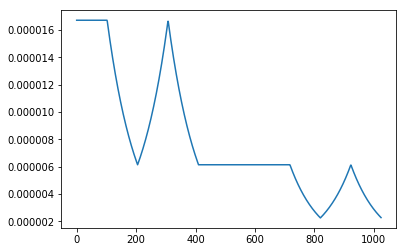

In [68]:
plt.plot(new_sps2[0])

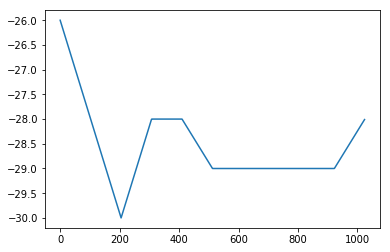

In [57]:
import matplotlib.pyplot as plt
plt.plot(np.log(new_sps2[0]))

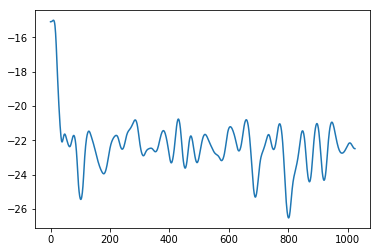

In [37]:
plt.plot(np.log(sps[0][0]))

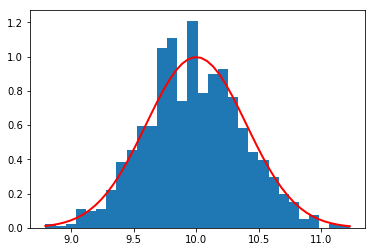

In [10]:
mu, sigma = 10, .4
s = np.random.normal(loc=mu, scale=sigma, size=1000)
import matplotlib.pyplot as plt
import scipy.stats as st
count, bins, _ = plt.hist(s, 30, normed=True)
# normed是进行拟合的关键
# count统计某一bin出现的次数，在Normed为True时，可能其值会略有不同
s_fit = np.linspace(s.min(), s.max())
plt.plot(s_fit, st.norm(mu, sigma).pdf(s_fit), lw=2, c='r')